In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import trange
from utils.create_data import *
from utils.data import *
from utils.metrics import plot_tsne
from utils.network_lstm import LSTMGenerator, LSTMDiscriminator, gen_model_rnn

Modèle très semblable à ``gan_cnn.ipynb`` mais l'architecture du generator et discriminator sont des [Long Short Term Memory](https://deeplearning.cs.cmu.edu/F23/document/readings/LSTM.pdf) (LSTM). Les LSTM sont une architecture de réseaux de neurones très utilisés lorsque les données suivent un ordre logique (par exemple les données temporelles, le langage naturel etc...). Comme son nom l'indique, les LSTM modélisent une dépendance temporelle de long terme et de court terme.

<img src="img/LSTM.png" alt="Texte alternatif" style="width: 800px;">

L'image ci dessus représente l'architecture d'un LSTM. $x_t$ représente l'input et $h_t$ l'output. Une partie de l'information de $x_t$ est ajouté à la variable $c_t$ qui représente l'information à long terme au temps $t$. La mémoire à court terme, elle est modélisée par le fait que la valeur de $h_{t-1}$ est utilisé en variable d'input au temps $t$. 

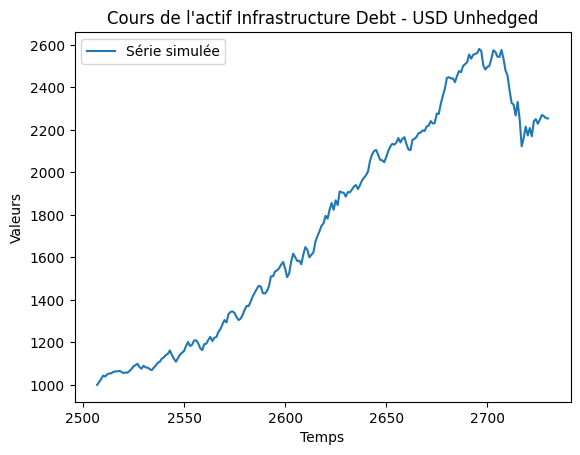

In [2]:
df = pd.read_csv('./data/GANData.csv')
actif = "Infrastructure Debt - USD Unhedged"
simple_plot(df[df['ASSETNAME']==actif]['PRICE'], f"Cours de l'actif {actif}")

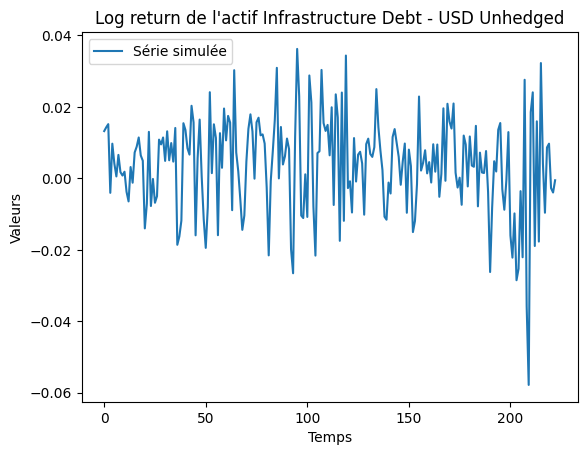

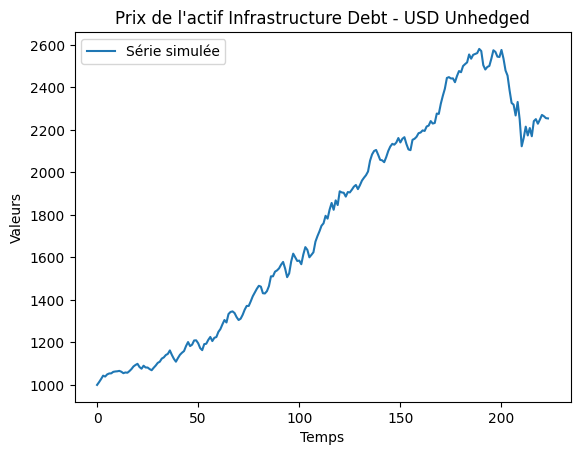

In [3]:
sdf = df[df['ASSETNAME']==actif]['PRICE']
y = np.log(sdf/sdf.shift(1))[1:].to_numpy()
true_y = df[df['ASSETNAME']==actif]['PRICE'].to_numpy()
simple_plot(y[:], f"Log return de l'actif {actif}")
simple_plot(true_y[:], f"Prix de l'actif {actif}")

In [4]:
latent_dim = 20 # Dimension du "bruit" d'entrée
ts_dim = 50 # Dimension de sortie
conditional = 10 # Dimension de la partie "commune"

generator = LSTMGenerator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)
discriminator = LSTMDiscriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

epochs = 600
batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = 'test'
print(use_cuda)

train = gen_model_rnn(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda)
train.train_model(epochs=epochs)

True


  0%|          | 0/600 [00:00<?, ?it/s]/home/onyxia/work/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1283: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
100%|██████████| 600/600 [01:57<00:00,  5.11it/s]


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

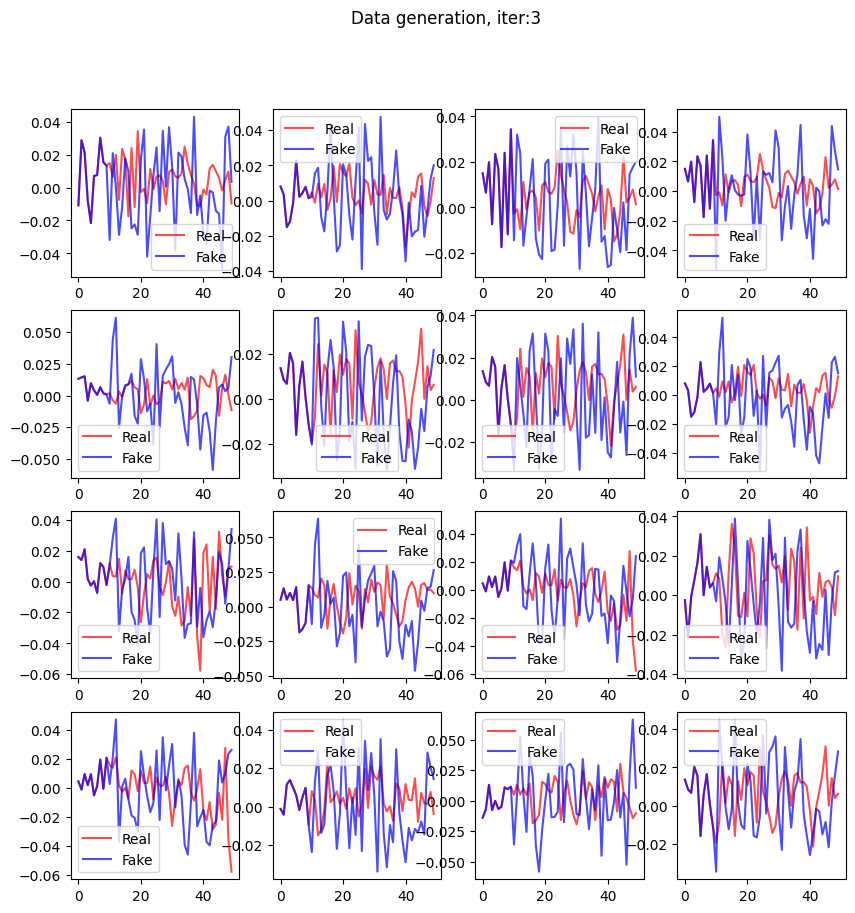

In [5]:
show_examples(train.real_lines, train.fake_lines, size=4)

In [6]:
train.ts_dim

50

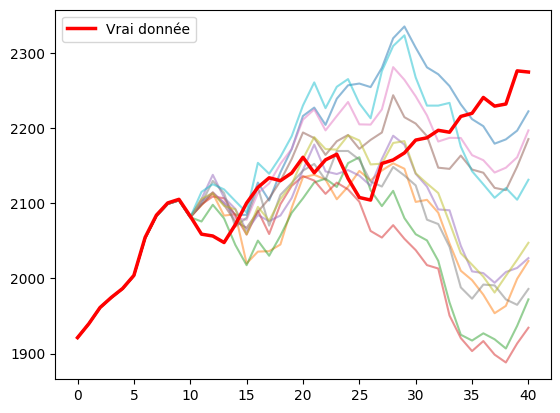

In [23]:
import random
def generate_fake_scenario(input_, true_input, train, amplifier = 1, num = 5):
    for i in range(num):
        conditional = train.conditional
        noise = torch.randn((1, 1, train.latent_dim))*amplifier
        real_samples = torch.from_numpy(input_[:conditional])
        noise[0][0][:conditional] = real_samples[:conditional]
        noise = noise.cuda()
        v = train.G(noise)/2
        v[0][0][:conditional] = real_samples[:conditional]
        croissance = np.array(v.float().cpu().detach()[0][0])
        fake_line = np.array([true_input[0]] + [true_input[0] * np.prod(1 + croissance[:i+1]) for i in range(40)])
        plt.plot(fake_line, alpha=0.5)
    plt.plot(true_input[:len(fake_line)], label=f'Vrai donnée', linewidth=2.5, color="red") 
    plt.legend()
    plt.show()
start = random.randint(0,200)

generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 1,num =10)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.095119
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.171238
[t-SNE] KL divergence after 300 iterations: 0.178212


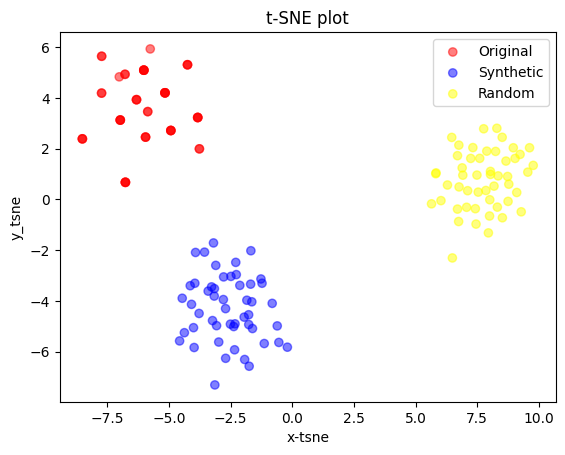

In [24]:
fake , real = train.data.get_samples(G = train.G, latent_dim = train.latent_dim, ts_dim = train.ts_dim, 
                    batch_size=50, conditional= train.conditional, use_cuda=True, data = train.data)
real_array = real.float().cpu().detach().numpy()
fake_array = fake.float().cpu().detach().numpy()
plot_tsne(real_array,fake_array, random=True)